# 43.2-modeling-ARIMA

> Given how the notebook 43.1-modeling-ARIMA-Stationary-Test shows which data is stationary. We apply log to normalize the data to test out how the predictions turn out

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pmdarima as pm
import os
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from pmdarima.arima import ADFTest
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

import numpy as np
from math import sqrt, exp
import warnings

# Load the data

In [86]:
#Constants/globals
os.chdir('/data/p_dsi/teams2023/team9/')
os.getcwd()

In [87]:
#load the data
data = pd.read_csv("Asurion_clean_data_feature_set.csv")
display(data.info())
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11684 entries, 0 to 11683
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   phone model       11684 non-null  object
 1   phone size        11684 non-null  object
 2   phone color       11684 non-null  object
 3   claim             11684 non-null  int64 
 4   weeks_monday      11684 non-null  object
 5   month             11684 non-null  object
 6   year              11684 non-null  int64 
 7   season            11684 non-null  object
 8   quarter           11684 non-null  object
 9   Holidays_Boolean  11684 non-null  bool  
 10  company           11684 non-null  object
 11  model_group       11684 non-null  object
dtypes: bool(1), int64(2), object(9)
memory usage: 1015.6+ KB


None

,phone model,phone size,phone color,claim,weeks_monday,month,year,season,quarter,Holidays_Boolean,company,model_group
0,apple iphone 11,128gb,black,252,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
1,apple iphone 11,128gb,green,45,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
2,apple iphone 11,128gb,purple,92,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
3,apple iphone 11,128gb,red,69,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
4,apple iphone 11,128gb,white,91,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
5,apple iphone 11,128gb,yellow,5,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
6,apple iphone 11,256gb,black,24,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
7,apple iphone 11,256gb,green,3,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
8,apple iphone 11,256gb,purple,7,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11
9,apple iphone 11,256gb,red,9,2022-01-24,January,2022,winter,Q1,False,apple,iphone 11


   weeks_monday  claim
0    2021-11-15      2
1    2021-11-22      3
2    2021-11-29      6
3    2021-12-06      2
4    2021-12-13     10
..          ...    ...
61   2023-01-16   3828
62   2023-01-23   4090
63   2023-01-30   3740
64   2023-02-06   4270
65   2023-02-13    847

[66 rows x 2 columns]
   weeks_monday  claim
0    2021-06-28   1499
1    2021-07-05   4068
2    2021-07-12   3753
3    2021-07-19   3664
4    2021-07-26   3583
..          ...    ...
81   2023-01-16   1856
82   2023-01-23   1751
83   2023-01-30   1536
84   2023-02-06   2157
85   2023-02-13    378

[86 rows x 2 columns]
   weeks_monday  claim
0    2021-06-28    422
1    2021-07-05   1017
2    2021-07-12   1045
3    2021-07-19   1144
4    2021-07-26   1157
..          ...    ...
81   2023-01-16   4277
82   2023-01-23   4136
83   2023-01-30   3764
84   2023-02-06   4604
85   2023-02-13    807

[86 rows x 2 columns]


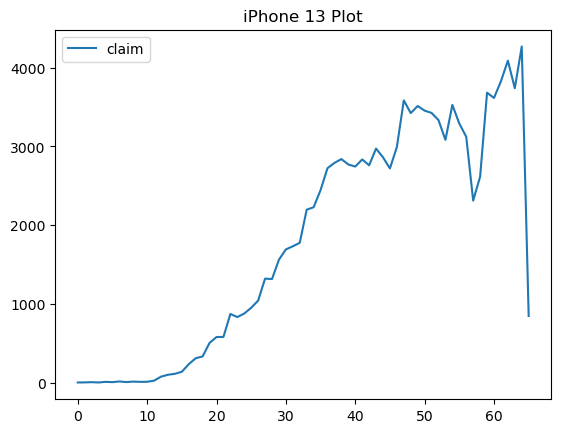

In [88]:
iphone13 = data[data["model_group"] == "iphone 13"]
result_iphone_13 = iphone13.groupby(['weeks_monday'], as_index = False).agg({'claim': np.sum})


print(result_iphone_13)
result_iphone_13.plot()
plt.title("iPhone 13 Plot")

iphone11 = data[data["model_group"] == "iphone 11"]
result_iphone_11 = iphone11.groupby(['weeks_monday'], as_index = False).agg({'claim': np.sum})

print(result_iphone_11)

iphone12 = data[data["model_group"] == "iphone 12"]
result_iphone_12 = iphone12.groupby(['weeks_monday'], as_index = False).agg({'claim': np.sum})

print(result_iphone_12)

,weeks_monday,claim
0,2021-11-15,2
1,2021-11-22,3
2,2021-11-29,6
3,2021-12-06,2
4,2021-12-13,10
...,...,...
60,2023-01-09,3616
61,2023-01-16,3828
62,2023-01-23,4090
63,2023-01-30,3740


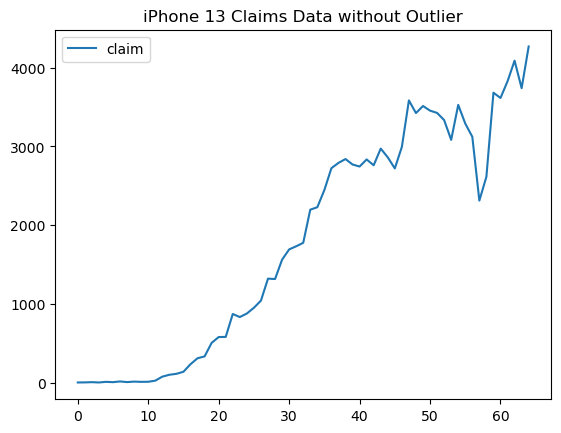

In [89]:
# Removing last data point as recommended by professor, we have reason to think that the data is an outlier due to
# the data being incomplete

result_iphone_13 = result_iphone_13[:65]

display(result_iphone_13)

result_iphone_13.plot()
plt.title("iPhone 13 Claims Data without Outlier")


result_iphone_11 = result_iphone_11[:-1]
result_iphone_12 = result_iphone_12[:-1]



In [90]:
result_iphone_13['weeks_monday'] = pd.to_datetime(result_iphone_13['weeks_monday'])
result_iphone_13.set_index('weeks_monday', inplace = True)

result_iphone_11['weeks_monday'] = pd.to_datetime(result_iphone_11['weeks_monday'])
result_iphone_11.set_index('weeks_monday', inplace = True)

result_iphone_12['weeks_monday'] = pd.to_datetime(result_iphone_12['weeks_monday'])
result_iphone_12.set_index('weeks_monday', inplace = True)

In [91]:
result_iphone_13_v1 = result_iphone_13.copy()

display(result_iphone_13.head())
result_iphone_13.info()

result_iphone_11_v1 = result_iphone_11.copy()

display(result_iphone_11.head())
result_iphone_11.info()

result_iphone_12_v1 = result_iphone_12.copy()

display(result_iphone_12.head())
result_iphone_12.info()

,claim
weeks_monday,
2021-11-15,2
2021-11-22,3
2021-11-29,6
2021-12-06,2
2021-12-13,10


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65 entries, 2021-11-15 to 2023-02-06
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   claim   65 non-null     int64
dtypes: int64(1)
memory usage: 1.0 KB


,claim
weeks_monday,
2021-06-28,1499
2021-07-05,4068
2021-07-12,3753
2021-07-19,3664
2021-07-26,3583


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85 entries, 2021-06-28 to 2023-02-06
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   claim   85 non-null     int64
dtypes: int64(1)
memory usage: 1.3 KB


,claim
weeks_monday,
2021-06-28,422
2021-07-05,1017
2021-07-12,1045
2021-07-19,1144
2021-07-26,1157


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85 entries, 2021-06-28 to 2023-02-06
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   claim   85 non-null     int64
dtypes: int64(1)
memory usage: 1.3 KB


Text(0.5, 1.0, 'iPhone 13 Claims Data')

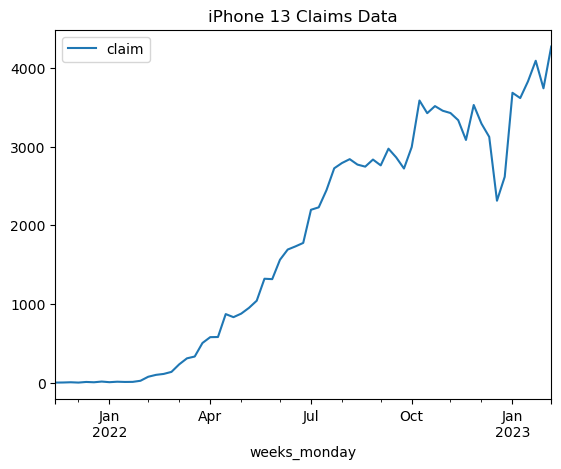

In [92]:
result_iphone_13.plot()
plt.title("iPhone 13 Claims Data")
# Plot has x-axis as weeks_monday

#### Methods to use to find hyper parameters in ARIMA below

In [95]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [96]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

## iPhone 13

In [93]:
result_iphone_13_v1['claim'] = result_iphone_13_v1['claim'].astype('float64')

result_iphone_13_v1

,claim
weeks_monday,
2021-11-15,2.0
2021-11-22,3.0
2021-11-29,6.0
2021-12-06,2.0
2021-12-13,10.0
...,...
2023-01-09,3616.0
2023-01-16,3828.0
2023-01-23,4090.0


In [94]:
# Apply log to the dataset
# Do not run this cell more than once unless you refresh the data from above first

result_iphone_13_v1['claim'] = np.log(result_iphone_13_v1['claim'])


display(result_iphone_13_v1)

,claim
weeks_monday,
2021-11-15,0.693147
2021-11-22,1.098612
2021-11-29,1.791759
2021-12-06,0.693147
2021-12-13,2.302585
...,...
2023-01-09,8.193124
2023-01-16,8.250098
2023-01-23,8.316300


,claim
weeks_monday,
2023-01-09,8.193124
2023-01-16,8.250098
2023-01-23,8.316300
2023-01-30,8.226841
2023-02-06,8.359369


In [179]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6]
d_values = range(0, 3)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(result_iphone_13_v1.values, p_values, d_values, q_values)

# This resulted in Best ARIMA(0, 1, 1) MSE= 0.015

ARIMA(0, 0, 0) MSE=4.791
ARIMA(0, 0, 1) MSE=1.429
ARIMA(0, 0, 2) MSE=0.608
ARIMA(0, 0, 3) MSE=0.302
ARIMA(0, 1, 0) MSE=0.015
ARIMA(0, 1, 1) MSE=0.015
ARIMA(0, 1, 2) MSE=0.022
ARIMA(0, 1, 3) MSE=0.022
ARIMA(0, 2, 0) MSE=0.031
ARIMA(0, 2, 1) MSE=0.021
ARIMA(0, 2, 2) MSE=0.018
ARIMA(0, 2, 3) MSE=0.021
ARIMA(1, 0, 0) MSE=0.017
ARIMA(1, 0, 1) MSE=0.016
ARIMA(1, 0, 2) MSE=0.024
ARIMA(1, 0, 3) MSE=0.024
ARIMA(1, 1, 0) MSE=0.016
ARIMA(1, 1, 1) MSE=0.017
ARIMA(1, 1, 2) MSE=0.019
ARIMA(1, 1, 3) MSE=0.020
ARIMA(1, 2, 0) MSE=0.031
ARIMA(1, 2, 1) MSE=0.021
ARIMA(1, 2, 2) MSE=0.021
ARIMA(1, 2, 3) MSE=0.020
ARIMA(2, 0, 0) MSE=0.017
ARIMA(2, 0, 1) MSE=0.018
ARIMA(2, 0, 2) MSE=0.020
ARIMA(2, 0, 3) MSE=0.045
ARIMA(2, 1, 0) MSE=0.021
ARIMA(2, 1, 1) MSE=0.021
ARIMA(2, 1, 2) MSE=0.020
ARIMA(2, 1, 3) MSE=0.021
ARIMA(2, 2, 0) MSE=0.030
ARIMA(2, 2, 1) MSE=0.022
ARIMA(2, 2, 2) MSE=0.021
ARIMA(2, 2, 3) MSE=0.023
ARIMA(4, 0, 0) MSE=0.024
ARIMA(4, 0, 1) MSE=0.024
ARIMA(4, 0, 2) MSE=199.947
ARIMA(4, 0, 3) MSE=0.03

In [1]:
df_train_manual = result_iphone_13_v1[:51]
df_test_manual = result_iphone_13_v1[-14:]

df_train_manual_original = result_iphone_13[:51]
df_test_manual_original = result_iphone_13[-14:]

NameError: name 'result_iphone_13_v1' is not defined

In [99]:
## Apply it on the training data
model_13 = ARIMA(df_train_manual, order=(0,1,1))
model_fit_13 = model_13.fit()
print(model_fit_13.summary())

                               SARIMAX Results                                
Dep. Variable:                  claim   No. Observations:                   51
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -28.190
Date:                Sun, 02 Apr 2023   AIC                             60.380
Time:                        21:43:47   BIC                             64.204
Sample:                    11-15-2021   HQIC                            61.837
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1735      0.089     -1.939      0.053      -0.349       0.002
sigma2         0.1807      0.024      7.589      0.000       0.134       0.227
Ljung-Box (L1) (Q):                   5.39   Jarque-

In [113]:
prediction_13 = pd.DataFrame(model_fit_13.forecast(len(df_test_manual)+7))
prediction_13.columns = ['predicted_values']
prediction_13

,predicted_values
2022-11-07,8.149797
2022-11-14,8.149797
2022-11-21,8.149797
2022-11-28,8.149797
2022-12-05,8.149797
2022-12-12,8.149797
2022-12-19,8.149797
2022-12-26,8.149797
2023-01-02,8.149797
2023-01-09,8.149797


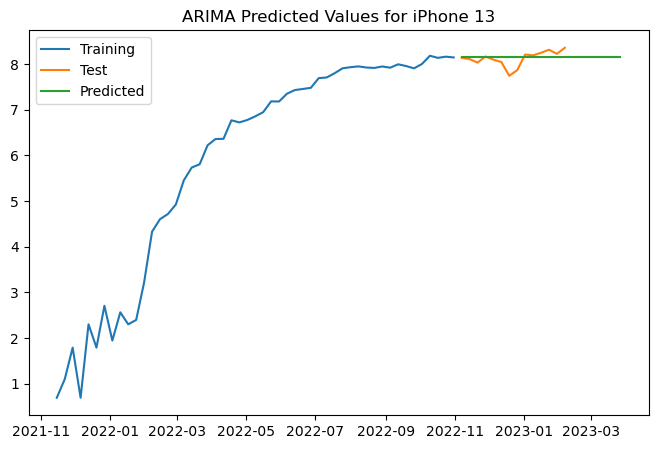

In [114]:
plt.figure(figsize=(8,5))
plt.plot(df_train_manual,label="Training")
plt.plot(df_test_manual,label="Test")
plt.plot(prediction_13,label="Predicted")
plt.legend(loc = 'upper left')
plt.title("ARIMA Predicted Values for iPhone 13")
plt.show()

In [115]:
prediction_13_test = prediction_13.copy()

prediction_13_test['true_predicted_values'] = np.exp(prediction_13_test['predicted_values'])

display(prediction_13_test)

,predicted_values,true_predicted_values
2022-11-07,8.149797,3462.677487
2022-11-14,8.149797,3462.677487
2022-11-21,8.149797,3462.677487
2022-11-28,8.149797,3462.677487
2022-12-05,8.149797,3462.677487
2022-12-12,8.149797,3462.677487
2022-12-19,8.149797,3462.677487
2022-12-26,8.149797,3462.677487
2023-01-02,8.149797,3462.677487
2023-01-09,8.149797,3462.677487


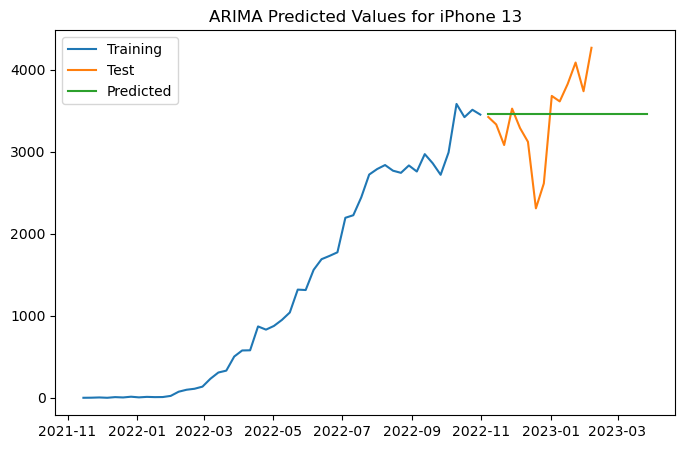

In [118]:
prediction_13_test = prediction_13_test.drop('predicted_values', axis = 1)

plt.figure(figsize=(8,5))
plt.plot(df_train_manual_original,label="Training")
plt.plot(df_test_manual_original,label="Test")
plt.plot(prediction_13_test,label="Predicted")
plt.legend(loc = 'upper left')
plt.title("ARIMA Log Transformed Predicted Values for iPhone 13")
plt.show()

In [189]:
calculation = prediction_13_test[0:14]

WMAPE_frames = [df_test_manual_original, calculation]
WMAPE_df = pd.concat(WMAPE_frames, axis = 1)

WMAPE_df['abs_val'] = abs(WMAPE_df['claim'] - WMAPE_df['true_predicted_values'])

WMAPE_df['weight'] = (WMAPE_df['abs_val'] / WMAPE_df['claim'] *100)*WMAPE_df['claim']

Total_Weight = WMAPE_df['weight'].sum()

Total_Claim = WMAPE_df['claim'].sum()


WMAPE = Total_Weight / Total_Claim

WMAPE

11.614033623962285

## iPhone 13 Applying Other ARIMA Model Test Version

In [176]:
model_13_v2 = ARIMA(df_train_manual, order=(2,1,4))
model_fit_13_v2 = model_13_v2.fit()
print(model_fit_13_v2.summary())

prediction_13_v2 = pd.DataFrame(model_fit_13_v2.forecast(len(df_test_manual)+7))
prediction_13_v2.columns = ['predicted_values']
prediction_13_v2

                               SARIMAX Results                                
Dep. Variable:                  claim   No. Observations:                   51
Model:                 ARIMA(2, 1, 4)   Log Likelihood                 -15.460
Date:                Sun, 02 Apr 2023   AIC                             44.920
Time:                        22:16:56   BIC                             58.304
Sample:                    11-15-2021   HQIC                            50.017
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5297      0.186      2.850      0.004       0.165       0.894
ar.L2          0.4386      0.201      2.185      0.029       0.045       0.832
ma.L1         -0.6324      0.400     -1.580      0.1

,predicted_values
2022-11-07,8.288177
2022-11-14,8.217766
2022-11-21,8.258498
2022-11-28,8.277851
2022-12-05,8.305966
2022-12-12,8.329346
2022-12-19,8.354060
2022-12-26,8.377405
2023-01-02,8.400610
2023-01-09,8.423139


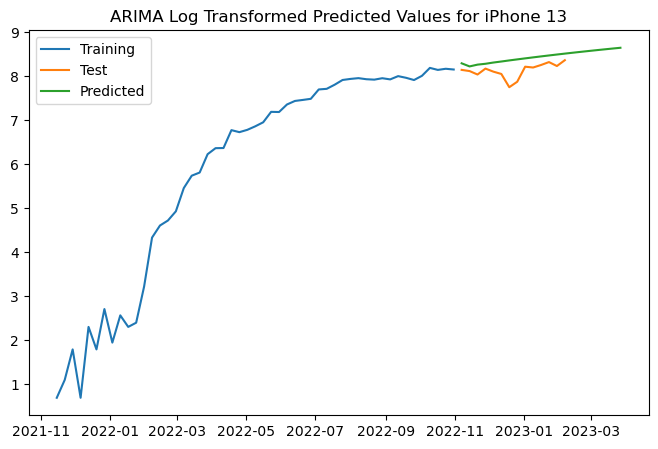

In [355]:
plt.figure(figsize=(8,5))
plt.plot(df_train_manual,label="Training")
plt.plot(df_test_manual,label="Test")
plt.plot(prediction_13_v2,label="Predicted")
plt.legend(loc = 'upper left')
plt.title("ARIMA Log Transformed Predicted Values for iPhone 13")
plt.show()

,predicted_values,true_predicted_values
2022-11-07,8.288177,3976.577150
2022-11-14,8.217766,3706.214896
2022-11-21,8.258498,3860.292657
2022-11-28,8.277851,3935.727531
2022-12-05,8.305966,4047.949905
2022-12-12,8.329346,4143.705325
2022-12-19,8.354060,4247.390889
2022-12-26,8.377405,4347.712028
2023-01-02,8.400610,4449.778980
2023-01-09,8.423139,4551.169333


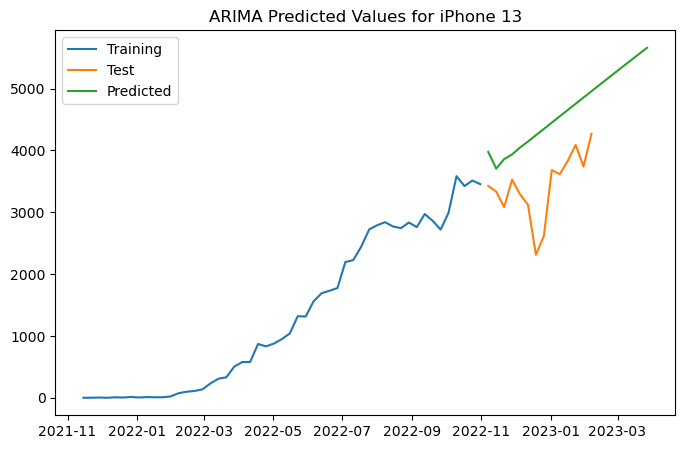

In [356]:
prediction_13_test_v2 = prediction_13_v2.copy()

prediction_13_test_v2['true_predicted_values'] = np.exp(prediction_13_test_v2['predicted_values'])

display(prediction_13_test_v2)

prediction_13_test_v2 = prediction_13_test_v2.drop('predicted_values', axis = 1)

plt.figure(figsize=(8,5))
plt.plot(df_train_manual_original,label="Training")
plt.plot(df_test_manual_original,label="Test")
plt.plot(prediction_13_test_v2,label="Predicted")
plt.legend(loc = 'upper left')
plt.title("ARIMA Predicted Values for iPhone 13")
plt.show()

In [190]:
calculation = prediction_13_test_v2[0:14]

WMAPE_frames = [df_test_manual_original, calculation]
WMAPE_df = pd.concat(WMAPE_frames, axis = 1)

WMAPE_df['abs_val'] = abs(WMAPE_df['claim'] - WMAPE_df['true_predicted_values'])

WMAPE_df['weight'] = (WMAPE_df['abs_val'] / WMAPE_df['claim'] *100)*WMAPE_df['claim']

Total_Weight = WMAPE_df['weight'].sum()

Total_Claim = WMAPE_df['claim'].sum()


WMAPE = Total_Weight / Total_Claim

WMAPE

26.167845975040446

## iPhone 11 Modeling

In [191]:
result_iphone_11_v1['claim'] = result_iphone_11_v1['claim'].astype('float64')

display(result_iphone_11_v1)

# Apply log to the dataset
# Do not run this cell more than once unless you refresh the data from above first

result_iphone_11_v1['claim'] = np.log(result_iphone_11_v1['claim'])

display(result_iphone_11_v1)

,claim
weeks_monday,
2021-06-28,7.312553
2021-07-05,8.310907
2021-07-12,8.230311
2021-07-19,8.206311
2021-07-26,8.183956
...,...
2023-01-09,7.529943
2023-01-16,7.526179
2023-01-23,7.467942


In [192]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6]
d_values = range(0, 3)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(result_iphone_11_v1.values, p_values, d_values, q_values)

# This resulted in ARIMA(0, 1, 1) MSE=0.012

ARIMA(0, 0, 0) MSE=0.051
ARIMA(0, 0, 1) MSE=0.022
ARIMA(0, 0, 2) MSE=0.017
ARIMA(0, 0, 3) MSE=0.023
ARIMA(0, 1, 0) MSE=0.012
ARIMA(0, 1, 1) MSE=0.012
ARIMA(0, 1, 2) MSE=0.012
ARIMA(0, 1, 3) MSE=0.012
ARIMA(0, 2, 0) MSE=0.024
ARIMA(0, 2, 1) MSE=0.013
ARIMA(0, 2, 2) MSE=0.013
ARIMA(0, 2, 3) MSE=0.014
ARIMA(1, 0, 0) MSE=0.012
ARIMA(1, 0, 1) MSE=0.012
ARIMA(1, 0, 2) MSE=0.013
ARIMA(1, 0, 3) MSE=0.013
ARIMA(1, 1, 0) MSE=0.013
ARIMA(1, 1, 1) MSE=0.012
ARIMA(1, 1, 2) MSE=0.013
ARIMA(1, 1, 3) MSE=0.012
ARIMA(1, 2, 0) MSE=0.021
ARIMA(1, 2, 1) MSE=0.013
ARIMA(1, 2, 2) MSE=0.015
ARIMA(1, 2, 3) MSE=0.013
ARIMA(2, 0, 0) MSE=0.013
ARIMA(2, 0, 1) MSE=0.013
ARIMA(2, 0, 2) MSE=0.013
ARIMA(2, 0, 3) MSE=0.013
ARIMA(2, 1, 0) MSE=0.012
ARIMA(2, 1, 1) MSE=0.013
ARIMA(2, 1, 2) MSE=0.013
ARIMA(2, 1, 3) MSE=0.013
ARIMA(2, 2, 0) MSE=0.019
ARIMA(2, 2, 1) MSE=0.013
ARIMA(2, 2, 2) MSE=0.015
ARIMA(2, 2, 3) MSE=0.015
ARIMA(4, 0, 0) MSE=0.013
ARIMA(4, 0, 1) MSE=0.013
ARIMA(4, 0, 2) MSE=0.014
ARIMA(4, 0, 3) MSE=0.014


In [194]:
df_train_manual_11 = result_iphone_11_v1[:68]
df_test_manual_11 = result_iphone_11_v1[-17:]

df_train_manual_original_11 = result_iphone_11[:68]
df_test_manual_original_11 = result_iphone_11[-17:]

In [195]:
## Apply it on the training data
model_11 = ARIMA(df_train_manual_11, order=(0,1,1))
model_fit_11 = model_11.fit()
print(model_fit_11.summary())

                               SARIMAX Results                                
Dep. Variable:                  claim   No. Observations:                   68
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  34.950
Date:                Sun, 02 Apr 2023   AIC                            -65.899
Time:                        22:44:58   BIC                            -61.490
Sample:                    06-28-2021   HQIC                           -64.155
                         - 10-10-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4917      0.105     -4.666      0.000      -0.698      -0.285
sigma2         0.0205      0.002     10.784      0.000       0.017       0.024
Ljung-Box (L1) (Q):                   6.45   Jarque-

In [196]:
prediction_11 = pd.DataFrame(model_fit_11.forecast(len(df_test_manual_11)+7))
prediction_11.columns = ['predicted_values']
prediction_11

,predicted_values
2022-10-17,7.860679
2022-10-24,7.860679
2022-10-31,7.860679
2022-11-07,7.860679
2022-11-14,7.860679
2022-11-21,7.860679
2022-11-28,7.860679
2022-12-05,7.860679
2022-12-12,7.860679
2022-12-19,7.860679


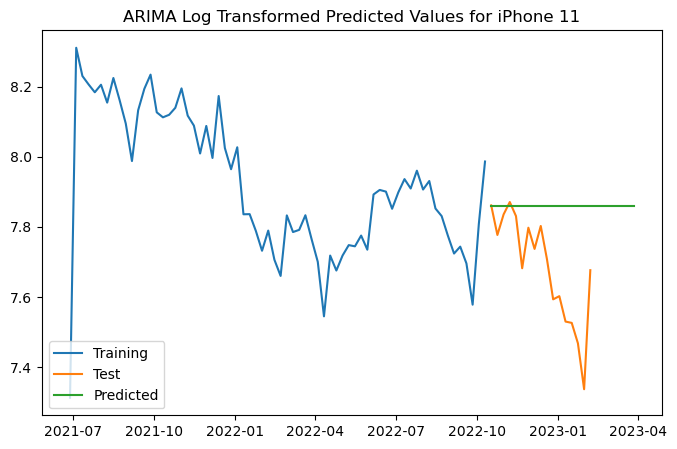

In [348]:
plt.figure(figsize=(8,5))
plt.plot(df_train_manual_11,label="Training")
plt.plot(df_test_manual_11,label="Test")
plt.plot(prediction_11,label="Predicted")
plt.legend(loc = 'lower left')
plt.title("ARIMA Log Transformed Predicted Values for iPhone 11")
plt.show()

In [344]:
prediction_11_test = prediction_11.copy()

prediction_11_test['true_predicted_values'] = np.exp(prediction_11_test['predicted_values'])

display(prediction_11_test)

prediction_11_test = prediction_11_test.drop('predicted_values', axis = 1)

,predicted_values,true_predicted_values
2022-10-17,7.860679,2593.279874
2022-10-24,7.860679,2593.279874
2022-10-31,7.860679,2593.279874
2022-11-07,7.860679,2593.279874
2022-11-14,7.860679,2593.279874
2022-11-21,7.860679,2593.279874
2022-11-28,7.860679,2593.279874
2022-12-05,7.860679,2593.279874
2022-12-12,7.860679,2593.279874
2022-12-19,7.860679,2593.279874


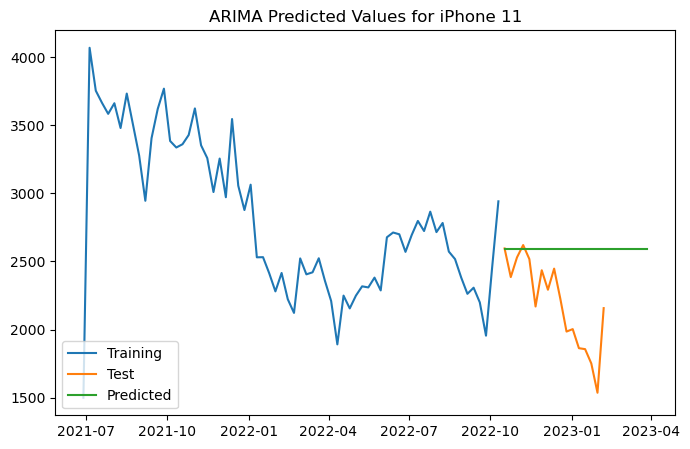

In [349]:
plt.figure(figsize=(8,5))
plt.plot(df_train_manual_original_11,label="Training")
plt.plot(df_test_manual_original_11,label="Test")
plt.plot(prediction_11_test,label="Predicted")
plt.legend(loc = 'lower left')
plt.title("ARIMA Predicted Values for iPhone 11")
plt.show()

In [346]:
calculation = prediction_11_test[0:17]

WMAPE_frames = [df_test_manual_original_11, calculation]
WMAPE_df = pd.concat(WMAPE_frames, axis = 1)

WMAPE_df['abs_val'] = abs(WMAPE_df['claim'] - WMAPE_df['true_predicted_values'])

WMAPE_df['weight'] = (WMAPE_df['abs_val'] / WMAPE_df['claim'] *100)*WMAPE_df['claim']

Total_Weight = WMAPE_df['weight'].sum()

Total_Claim = WMAPE_df['claim'].sum()


WMAPE = Total_Weight / Total_Claim

WMAPE

18.13584102985352

## iPhone 12 Model

In [203]:
result_iphone_12_v1['claim'] = result_iphone_12_v1['claim'].astype('float64')

display(result_iphone_12_v1)

# Apply log to the dataset
# Do not run this cell more than once unless you refresh the data from above first

result_iphone_12_v1['claim'] = np.log(result_iphone_12_v1['claim'])

display(result_iphone_12_v1)

,claim
weeks_monday,
2021-06-28,422.0
2021-07-05,1017.0
2021-07-12,1045.0
2021-07-19,1144.0
2021-07-26,1157.0
...,...
2023-01-09,3959.0
2023-01-16,4277.0
2023-01-23,4136.0


,claim
weeks_monday,
2021-06-28,6.045005
2021-07-05,6.924612
2021-07-12,6.951772
2021-07-19,7.042286
2021-07-26,7.053586
...,...
2023-01-09,8.283747
2023-01-16,8.361007
2023-01-23,8.327484


In [204]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6]
d_values = range(0, 3)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(result_iphone_12_v1.values, p_values, d_values, q_values)

# This resulted in ARIMA(0, 1, 1) MSE=0.010

ARIMA(0, 0, 0) MSE=0.336
ARIMA(0, 0, 1) MSE=0.117
ARIMA(0, 0, 2) MSE=0.079
ARIMA(0, 0, 3) MSE=0.049
ARIMA(0, 1, 0) MSE=0.011
ARIMA(0, 1, 1) MSE=0.010
ARIMA(0, 1, 2) MSE=0.011
ARIMA(0, 1, 3) MSE=0.012
ARIMA(0, 2, 0) MSE=0.026
ARIMA(0, 2, 1) MSE=0.012
ARIMA(0, 2, 2) MSE=0.011
ARIMA(0, 2, 3) MSE=0.011
ARIMA(1, 0, 0) MSE=0.011
ARIMA(1, 0, 1) MSE=0.011
ARIMA(1, 0, 2) MSE=0.011
ARIMA(1, 0, 3) MSE=0.012
ARIMA(1, 1, 0) MSE=0.010
ARIMA(1, 1, 1) MSE=0.011
ARIMA(1, 1, 2) MSE=0.012
ARIMA(1, 1, 3) MSE=0.012
ARIMA(1, 2, 0) MSE=0.020
ARIMA(1, 2, 1) MSE=0.011
ARIMA(1, 2, 2) MSE=0.012
ARIMA(1, 2, 3) MSE=0.012
ARIMA(2, 0, 0) MSE=0.011
ARIMA(2, 0, 1) MSE=0.011
ARIMA(2, 0, 2) MSE=0.012
ARIMA(2, 0, 3) MSE=0.012
ARIMA(2, 1, 0) MSE=0.011
ARIMA(2, 1, 1) MSE=0.011
ARIMA(2, 1, 2) MSE=0.012
ARIMA(2, 1, 3) MSE=0.011
ARIMA(2, 2, 0) MSE=0.016
ARIMA(2, 2, 1) MSE=0.011
ARIMA(2, 2, 2) MSE=0.012
ARIMA(2, 2, 3) MSE=0.013
ARIMA(4, 0, 0) MSE=0.012
ARIMA(4, 0, 1) MSE=0.012
ARIMA(4, 0, 2) MSE=0.015
ARIMA(4, 0, 3) MSE=0.013


In [327]:
df_train_manual_12 = result_iphone_12_v1[:68]
df_test_manual_12 = result_iphone_12_v1[-17:]

df_train_manual_original_12 = result_iphone_12[:68]
df_test_manual_original_12 = result_iphone_12[-17:]

In [209]:
## Apply it on the training data
model_12 = ARIMA(df_train_manual_12, order=(0,1,1))
model_fit_12 = model_12.fit()
print(model_fit_12.summary())

                               SARIMAX Results                                
Dep. Variable:                  claim   No. Observations:                   68
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  32.717
Date:                Sun, 02 Apr 2023   AIC                            -61.433
Time:                        22:54:02   BIC                            -57.024
Sample:                    06-28-2021   HQIC                           -59.689
                         - 10-10-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0334      0.171     -0.195      0.845      -0.369       0.302
sigma2         0.0220      0.001     17.102      0.000       0.020       0.025
Ljung-Box (L1) (Q):                   0.05   Jarque-

In [210]:
prediction_12 = pd.DataFrame(model_fit_12.forecast(len(df_test_manual_12)+7))
prediction_12.columns = ['predicted_values']
prediction_12

,predicted_values
2022-10-17,8.460701
2022-10-24,8.460701
2022-10-31,8.460701
2022-11-07,8.460701
2022-11-14,8.460701
2022-11-21,8.460701
2022-11-28,8.460701
2022-12-05,8.460701
2022-12-12,8.460701
2022-12-19,8.460701


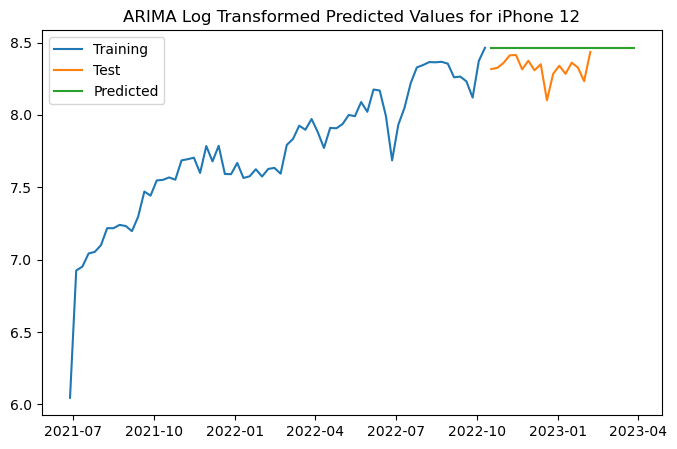

In [350]:
plt.figure(figsize=(8,5))
plt.plot(df_train_manual_12,label="Training")
plt.plot(df_test_manual_12,label="Test")
plt.plot(prediction_12,label="Predicted")
plt.legend(loc = 'upper left')
plt.title("ARIMA Log Transformed Predicted Values for iPhone 12")
plt.show()

In [332]:
prediction_12_test = prediction_12.copy()

prediction_12_test['true_predicted_values'] = np.exp(prediction_12_test['predicted_values'])

display(prediction_12_test)

,predicted_values,true_predicted_values
2022-10-17,8.460701,4725.367424
2022-10-24,8.460701,4725.367424
2022-10-31,8.460701,4725.367424
2022-11-07,8.460701,4725.367424
2022-11-14,8.460701,4725.367424
2022-11-21,8.460701,4725.367424
2022-11-28,8.460701,4725.367424
2022-12-05,8.460701,4725.367424
2022-12-12,8.460701,4725.367424
2022-12-19,8.460701,4725.367424


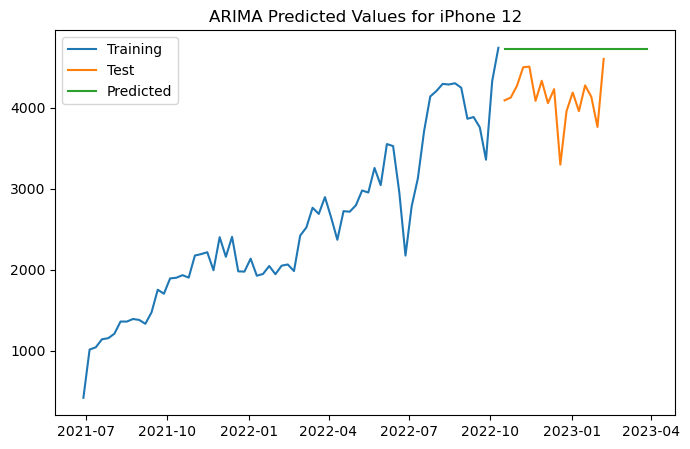

In [333]:
prediction_12_test = prediction_12_test.drop('predicted_values', axis = 1)

plt.figure(figsize=(8,5))
plt.plot(df_train_manual_original_12,label="Training")
plt.plot(df_test_manual_original_12,label="Test")
plt.plot(prediction_12_test,label="Predicted")
plt.legend(loc = 'upper left')
plt.title("ARIMA Predicted Values for iPhone 12")
plt.show()

In [334]:
calculation = prediction_12_test[0:17]

WMAPE_frames = [df_test_manual_original_12, calculation]
WMAPE_df = pd.concat(WMAPE_frames, axis = 1)

WMAPE_df['abs_val'] = abs(WMAPE_df['claim'] - WMAPE_df['true_predicted_values'])

WMAPE_df['weight'] = (WMAPE_df['abs_val'] / WMAPE_df['claim'] *100)*WMAPE_df['claim']

Total_Weight = WMAPE_df['weight'].sum()

Total_Claim = WMAPE_df['claim'].sum()


WMAPE = Total_Weight / Total_Claim

WMAPE

14.11336753684796

#### Applying Other ARIMA Calculation Version

In [314]:
## Apply it on the training data
model_12_v2 = ARIMA(df_train_manual_12, order=(1,0,2))
model_fit_12_v2 = model_12_v2.fit()
print(model_fit_12_v2.summary())

                               SARIMAX Results                                
Dep. Variable:                  claim   No. Observations:                   68
Model:                 ARIMA(1, 0, 2)   Log Likelihood                  31.681
Date:                Sun, 02 Apr 2023   AIC                            -53.362
Time:                        23:10:36   BIC                            -42.264
Sample:                    06-28-2021   HQIC                           -48.965
                         - 10-10-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3874      0.975      7.577      0.000       5.476       9.298
ar.L1          0.9863      0.038     25.681      0.000       0.911       1.062
ma.L1         -0.0068      0.162     -0.042      0.9

In [322]:
prediction_12_v2 = pd.DataFrame(model_fit_12_v2.forecast(len(df_test_manual_12)+7))
prediction_12_v2.columns = ['predicted_values']
prediction_12_v2

,predicted_values
2022-10-17,8.486110
2022-10-24,8.488276
2022-10-31,8.473236
2022-11-07,8.458402
2022-11-14,8.443770
2022-11-21,8.429338
2022-11-28,8.415103
2022-12-05,8.401063
2022-12-12,8.387215
2022-12-19,8.373556


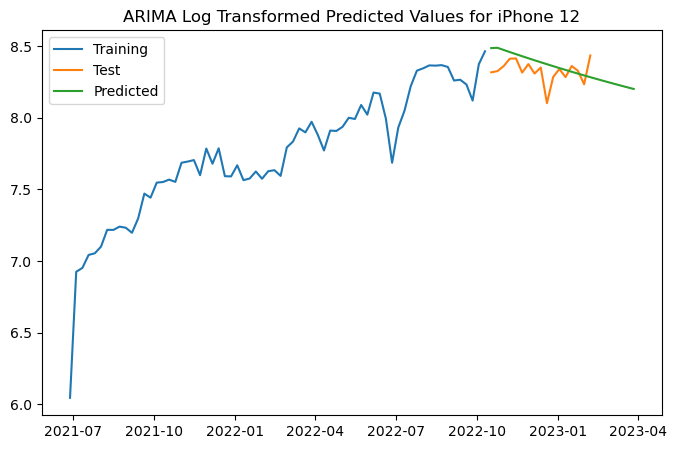

In [316]:
plt.figure(figsize=(8,5))
plt.plot(df_train_manual_12,label="Training")
plt.plot(df_test_manual_12,label="Test")
plt.plot(prediction_12_v2,label="Predicted")
plt.legend(loc = 'upper left')
plt.title("ARIMA Log Transformed Predicted Values for iPhone 12")
plt.show()

In [340]:

prediction_12_test_v2 = prediction_12_v2.copy()

prediction_12_test_v2['true_predicted_values'] = np.exp(prediction_12_test_v2['predicted_values'])

display(prediction_12_test_v2)

prediction_12_test_v2 = prediction_12_test_v2.drop('predicted_values', axis = 1)

,predicted_values,true_predicted_values
2022-10-17,8.486110,4846.973307
2022-10-24,8.488276,4857.483494
2022-10-31,8.473236,4784.974366
2022-11-07,8.458402,4714.516207
2022-11-14,8.443770,4646.037028
2022-11-21,8.429338,4579.467849
2022-11-28,8.415103,4514.742546
2022-12-05,8.401063,4451.797722
2022-12-12,8.387215,4390.572574
2022-12-19,8.373556,4331.008774


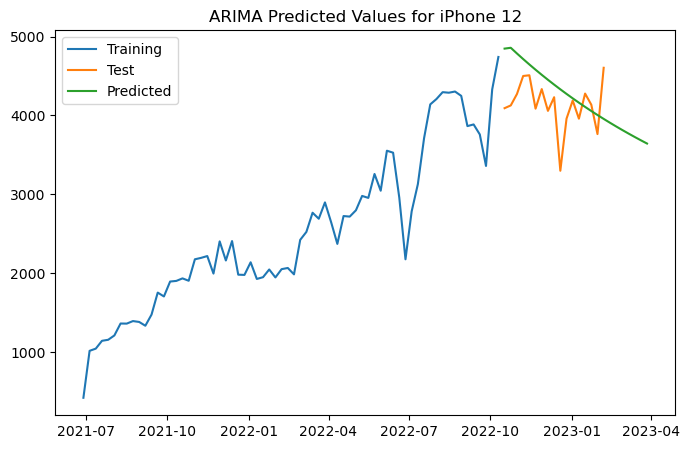

In [341]:
plt.figure(figsize=(8,5))
plt.plot(df_train_manual_original_12,label="Training")
plt.plot(df_test_manual_original_12,label="Test")
plt.plot(prediction_12_test_v2,label="Predicted")
plt.legend(loc = 'upper left')
plt.title("ARIMA Predicted Values for iPhone 12")
plt.show()

In [342]:
calculation = prediction_12_test_v2[0:17]

WMAPE_frames = [df_test_manual_original_12, calculation]
WMAPE_df = pd.concat(WMAPE_frames, axis = 1)

WMAPE_df['abs_val'] = abs(WMAPE_df['claim'] - WMAPE_df['true_predicted_values'])

WMAPE_df['weight'] = (WMAPE_df['abs_val'] / WMAPE_df['claim'] *100)*WMAPE_df['claim']

Total_Weight = WMAPE_df['weight'].sum()

Total_Claim = WMAPE_df['claim'].sum()


WMAPE = Total_Weight / Total_Claim

WMAPE

8.93783589678538